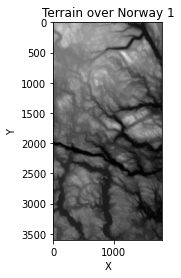

In [4]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
# Load the terrain
terrain = imread('data/SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [13]:
def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

In [35]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

z = terrain[1500:, :500]
z = (z - np.mean(z)) / np.std(z)  # scale the output data

x = np.linspace(0,1, np.shape(z)[0])
y = np.linspace(0,1, np.shape(z)[1])
x, y = np.meshgrid(x,y)

# __OLS__

In [46]:
from sklearn.linear_model import LinearRegression

RANDOM_STATE = 42
max_degree = 6

train_MSE = np.zeros(max_degree)
test_MSE = np.zeros(max_degree)
cv_score = np.zeros(max_degree)

for i in tqdm(range(max_degree)):
    X = create_X(x, y, i)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, z_train)
    z_tilde = model.predict(X_train)
    z_pred = model.predict(X_test)

    train_MSE[i] = mean_squared_error(z_tilde, z_train)
    test_MSE[i] = mean_squared_error(z_pred, z_test)

for i in tqdm(range(max_degree)):
    X = create_X(x, y, i)
    model = make_pipeline(StandardScaler(), LinearRegression())
    cv_score[i] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10)))

100%|██████████| 6/6 [00:32<00:00,  5.48s/it]


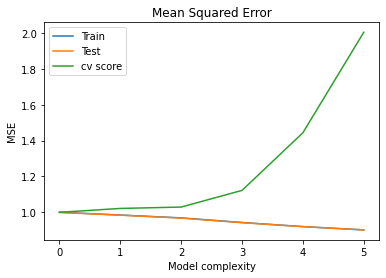

In [45]:
fig, ax = plt.subplots()
ax.set_title('Mean Squared Error')
ax.plot(range(max_degree), train_MSE, label='Train')
ax.plot(range(max_degree), test_MSE, label='Test')
ax.plot(range(max_degree), cv_score, label='cv score')
ax.legend()
ax.set_xlabel('Model complexity')
ax.set_ylabel('MSE')
plt.show()

# __Ridge__

In [47]:
from sklearn.linear_model import Ridge

num_lambdas = 10
degree = 4

lambdas = np.logspace(-4, 4, num_lambdas)
cv_score = np.zeros(num_lambdas)
cv_score_itr = 0

for lmb in tqdm(lambdas):
    X = create_X(x, y, degree)
    model = make_pipeline(StandardScaler(), Ridge(lmb, fit_intercept=False))
    cv_score[cv_score_itr] = -np.mean(cross_val_score(model, X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=KFold(10)))
    cv_score_itr += 1

100%|██████████| 20/20 [02:41<00:00,  8.10s/it]


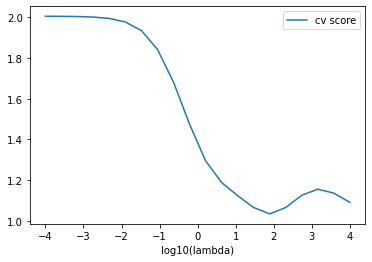

In [49]:
fig, ax = plt.subplots()
ax.plot(np.log10(lambdas), cv_score, label='cv score')
ax.set_xlabel('log10(lambda)')
# ax.set_title('Degree of polynomial: {}'.format(degree))
ax.legend()
plt.show()